## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [34]:
def build_mlp(input_shape, l_type, l_rate, num_output=10, num_neurons=[512, 256, 128, 64, 32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, units in enumerate(num_neurons):
        if i == 0:
            input_data = input_layer
        
        input_data = keras.layers.Dense(units=units, activation='relu', kernel_regularizer=l_type(l_rate), name= 'hidden_layer' + str(i + 1))(input_data)
    
    out = keras.layers.Dense(units=num_output, activation='softmax', name='output')(input_data)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [38]:
def train_model(epochs, batch_size, momentum, optimizer, l_type, l_rate):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("EPOCHS:%d, BATCH_SIZE:%d, MOMENTUM:%.4f, OPTIMIZER:%s\n" % (epochs, batch_size, momentum, optimizer))
    model = build_mlp(input_shape=x_train.shape[1:], l_type=l_type, l_rate=l_rate)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-regularizer-%s" % str(l_type)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    return results

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plotResult(results):
    plt.figure(figsize=(8, 6))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [40]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

Selected Regularizer:0.01
EPOCHS:50, BATCH_SIZE:256, MOMENTUM:0.9500, OPTIMIZER:sgd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_________________________________________________________

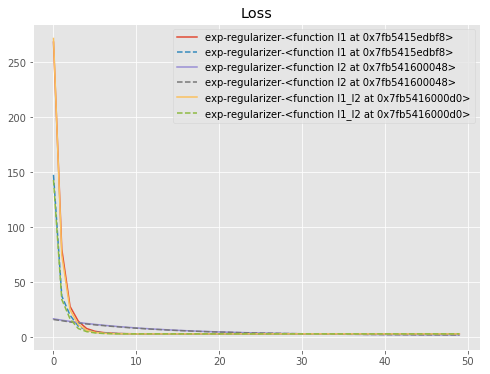

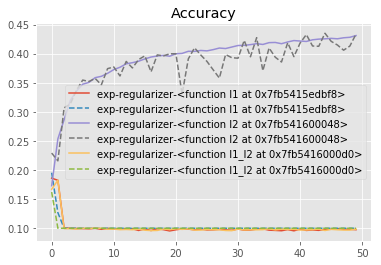

Selected Regularizer:0.0001
EPOCHS:50, BATCH_SIZE:256, MOMENTUM:0.9500, OPTIMIZER:sgd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_______________________________________________________

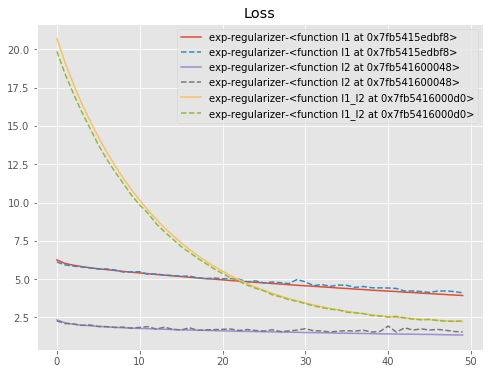

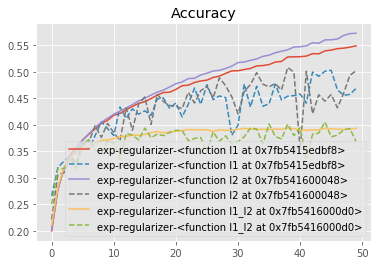

Selected Regularizer:1e-08
EPOCHS:50, BATCH_SIZE:256, MOMENTUM:0.9500, OPTIMIZER:sgd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
________________________________________________________

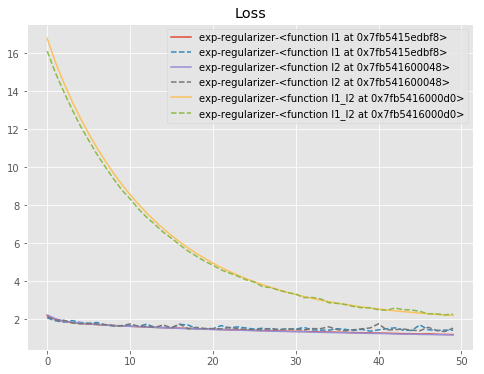

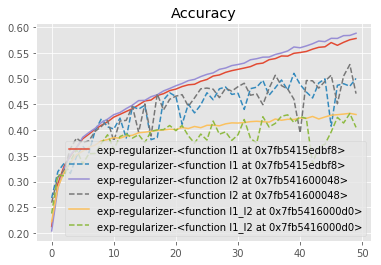

Selected Regularizer:1e-12
EPOCHS:50, BATCH_SIZE:256, MOMENTUM:0.9500, OPTIMIZER:sgd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
________________________________________________________

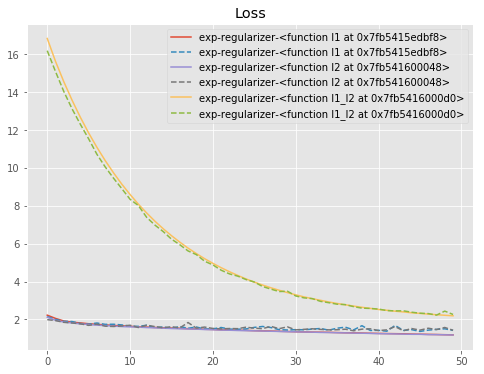

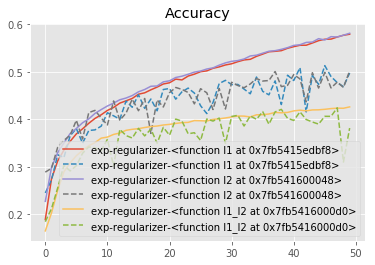

In [41]:
l_type_list = [l1, l2, l1_l2]

for l_rate in L_EXP:
    results = {}
    print(f'Selected Regularizer:{l_rate}')
    for l_type in l_type_list:
        results.update(train_model(epochs=EPOCHS, batch_size=BATCH_SIZE, momentum=MOMENTUM, optimizer='sgd', l_type=l_type, l_rate=l_rate))
    
    plotResult(results=results)

* 以相同的 Hyperparameter 進行測試後發現，收斂效果以及預測精度的排序為：l2 > l1 > l1_l2。